# Exploratory data analysis


## Library requirements

In [33]:
import pandas as pd
import re
import seaborn as sns

## Auxiliary functions


In [38]:
def valid_eval(selfeval: str) -> bool:
    """Returns true if given value have a valid format for self evaluation
    
    Args:
        selfeval (str): Candidate for self evaluation value.
    
    Returns:
        (bool): Validity for given self evaluation value
    """
    try:
        val = bool(re.match(r"^[0-5]\|[0-5]\|[0-5]_[0-5]\|[0-5]\|[0-5]$",selfeval))
    except TypeError:
        val = False
    return val

## Data


### EmpatheticDialogues

In [84]:
!wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
!tar -xzvf empatheticdialogues.tar.gz

--2021-05-23 06:25:17--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz.1’

empatheticdialogues 100%[===================>]  26.72M  7.87MB/s    in 3.4s    

2021-05-23 06:25:22 (7.87 MB/s) - ‘empatheticdialogues.tar.gz.1’ saved [28022709/28022709]

empatheticdialogues/
empatheticdialogues/test.csv
empatheticdialogues/train.csv
empatheticdialogues/valid.csv


In [85]:
!sed -i 's/"/\\"/g' empatheticdialogues/train.csv
!sed -i 's/"/\\"/g' empatheticdialogues/valid.csv
!sed -i 's/"/\\"/g' empatheticdialogues/test.csv

In [99]:
empdialogues_train = pd.read_csv("empatheticdialogues/train.csv", sep=",", encoding='utf-8', engine="python", escapechar="\\")
empdialogues_train.shape

(84169, 8)

In [32]:
empdialogues_train.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


### GoEmotions

We're using the GoEmotions dataset to extend _EmpatheticDialoges_ with neutral emotions

According to the emotions index [here](https://github.com/google-research/google-research/raw/master/goemotions/data/emotions.txt) The index we're interested in is _27_

In [ ]:
!wget https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv
!wget https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv
!wget https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv

In [62]:
goemotions_train = pd.read_csv("train.tsv", sep="\t", header=None)
goemotions_train.columns = ["utterance", "context", "id"]
goemotions_train = goemotions_train[goemotions_train["context"] == "27"]
goemotions_train.shape

(12823, 3)

In [63]:
goemotions_train["context"] = "neutral"
goemotions_train.drop(["id"], axis=1, inplace=True)
goemotions_train.head()

,utterance,context
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
9,It might be linked to the trust factor of your...,neutral
12,Hello everyone. Im from Toronto as well. Can c...,neutral
18,that is what retardation looks like,neutral


## Explorations

### Emotion Detection

In [34]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

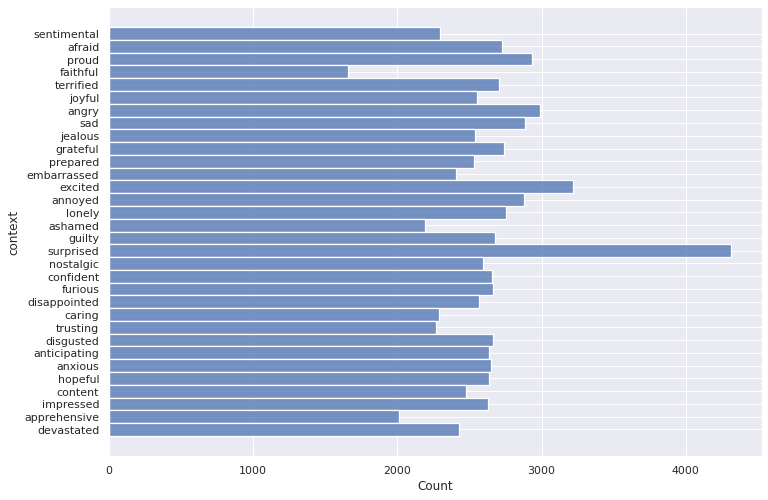

In [37]:
sns.histplot(empdialogues_train, y="context")

#### Filtering emotion classification data

In [47]:
emotion_data = empdialogues_train[(empdialogues_train["utterance_idx"] % 2) == 1]
emotion_data = emotion_data[["utterance", "context"]]
emotion_data.head()

,utterance,context
0,I remember going to see the fireworks with my ...,sentimental
2,This was a best friend. I miss her.,sentimental
4,We no longer talk.,sentimental
6,it feels like hitting to blank wall when i se...,afraid
8,dont you feel so.. its a wonder,afraid


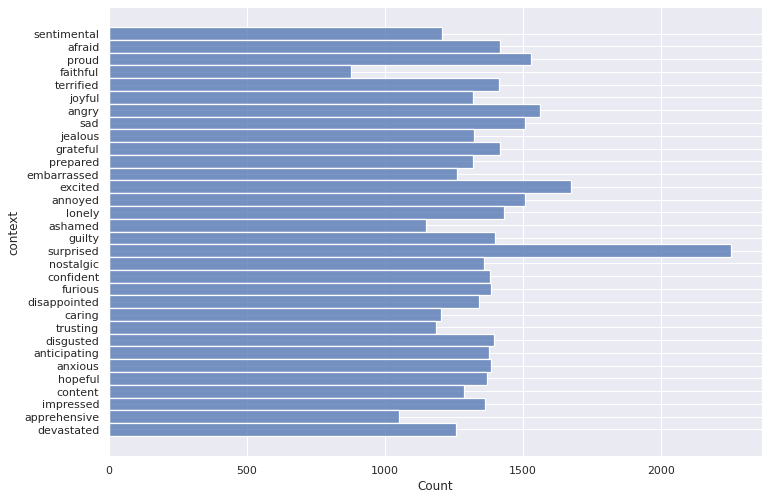

In [49]:
sns.histplot(emotion_data, y="context")

Lets compare the number of words per utterance to ensure compatibility between datasets

In [70]:
emotion_data["n_words"] = emotion_data["utterance"].apply(lambda x: len(x.split(" ")))

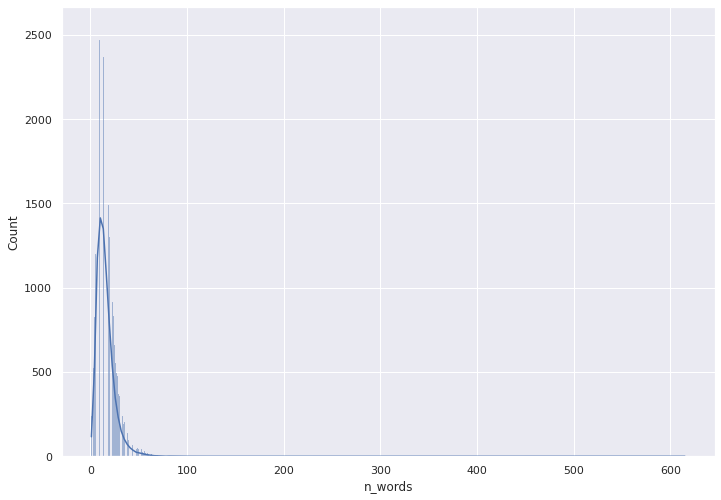

In [59]:
sns.histplot(emotion_data, x="n_words", kde=True)

In [69]:
goemotions_train["n_words"] = goemotions_train["utterance"].apply(lambda x: len(x.split(" ")))

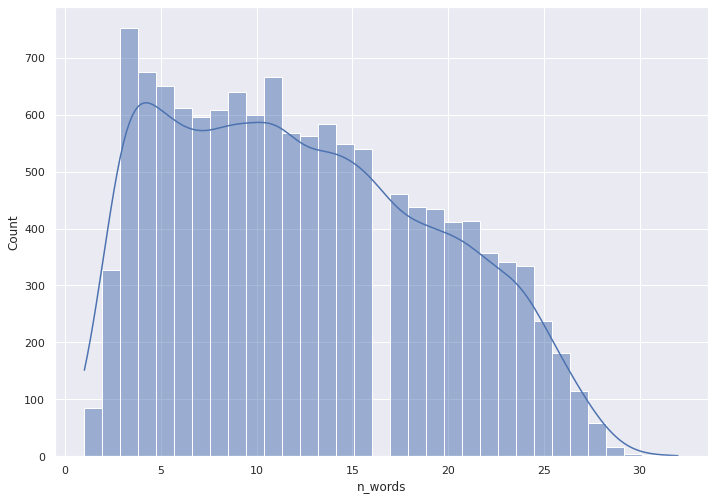

In [64]:
sns.histplot(goemotions_train, x="n_words", kde=True)

This indicates no additional words will be added as part of the new GoEmotions
dataset

In [71]:
emotion_data.drop(["n_words"], axis=1, inplace=True)
goemotions_train.drop(["n_words"], axis=1, inplace=True)

emotion_data_w_neutral = pd.concat([emotion_data, goemotions_train], axis=0)
emotion_data_w_neutral.shape

(56738, 2)

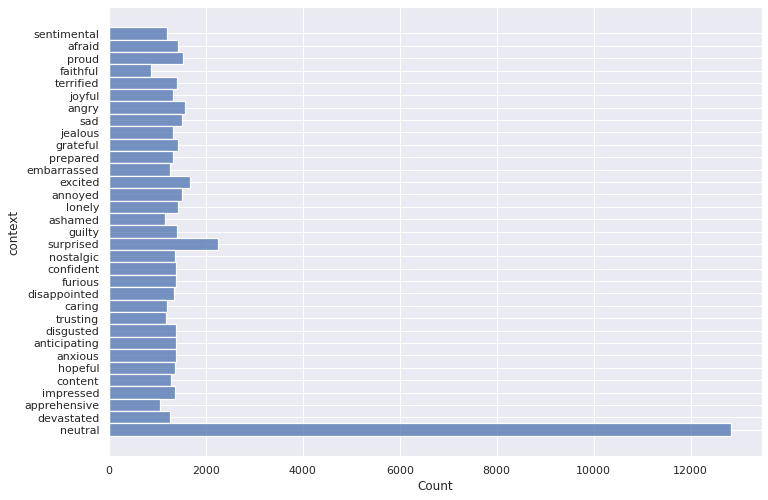

In [73]:
sns.histplot(emotion_data_w_neutral, y="context")

In [74]:
emotion_data_w_neutral_bin = emotion_data_w_neutral
emotion_data_w_neutral_bin["emotion"] = emotion_data_w_neutral_bin["context"].apply(lambda x: int(x != "neutral"))
emotion_data_w_neutral_bin.drop(["context"], axis=1, inplace=True)

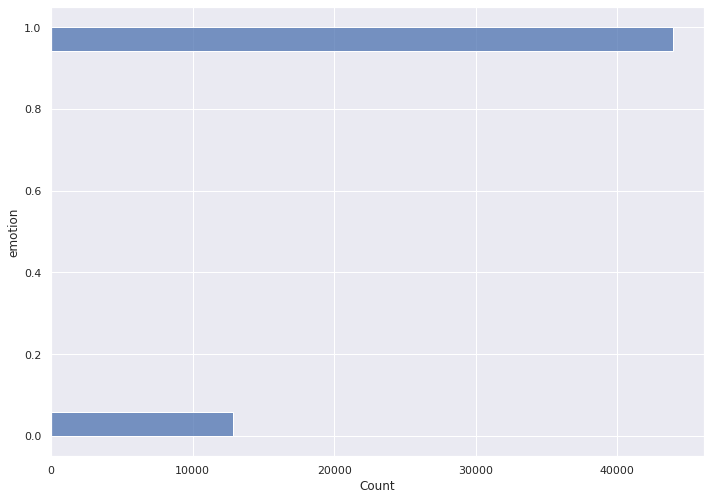

In [75]:
sns.histplot(emotion_data_w_neutral_bin, y="emotion")

In [77]:
emotion_data_w_neutral_bin["emotion"].value_counts(normalize=True)

1    0.773996
0    0.226004
Name: emotion, dtype: float64

In [81]:
emotion_data_w_neutral_bin.head()

,utterance,emotion
0,I remember going to see the fireworks with my ...,1
2,This was a best friend. I miss her.,1
4,We no longer talk.,1
6,it feels like hitting to blank wall when i se...,1
8,dont you feel so.. its a wonder,1


In [80]:
emotion_data_w_neutral_bin.to_csv("emotion_data_bin.csv", index=False)

#### Validation test generation

In [127]:
empdialogues_valid = pd.read_csv("empatheticdialogues/valid.csv", sep=",", encoding='utf-8', engine="python", escapechar="\\", error_bad_lines=False)

Streaming output truncated to the last 5000 lines.
Skipping line 1574: Expected 8 fields in line 1574, saw 9
Skipping line 1576: Expected 8 fields in line 1576, saw 9
Skipping line 1578: Expected 8 fields in line 1578, saw 9
Skipping line 1580: Expected 8 fields in line 1580, saw 9
Skipping line 1582: Expected 8 fields in line 1582, saw 9
Skipping line 1584: Expected 8 fields in line 1584, saw 9
Skipping line 1586: Expected 8 fields in line 1586, saw 9
Skipping line 1589: Expected 8 fields in line 1589, saw 9
Skipping line 1591: Expected 8 fields in line 1591, saw 9
Skipping line 1593: Expected 8 fields in line 1593, saw 9
Skipping line 1595: Expected 8 fields in line 1595, saw 9
Skipping line 1597: Expected 8 fields in line 1597, saw 9
Skipping line 1599: Expected 8 fields in line 1599, saw 9
Skipping line 1601: Expected 8 fields in line 1601, saw 9
Skipping line 1603: Expected 8 fields in line 1603, saw 9
Skipping line 1605: Expected 8 fields in line 1605, saw 9
Skipping line 1607: E

In [128]:
empdialogues_valid

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,4|5|5_5|5|5,NaN
1,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,4|5|5_5|5|5,NaN
2,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,4|5|5_5|5|5,NaN
3,hit:4_conv:9,1,surprised,I was walking through my hallway a few week ag...,8,A few weeks ago_comma_ I was walking through m...,5|5|5_3|5|5,NaN
4,hit:4_conv:9,3,surprised,I was walking through my hallway a few week ag...,8,I may have let out a scream that will have him...,5|5|5_3|5|5,NaN
...,...,...,...,...,...,...,...,...
6335,hit:12350_conv:24701,5,prepared,When I went into labor with my son_comma_ it w...,791,In the end_comma_ yes--growing too big is actu...,5|5|5_5|5|5,NaN
6336,hit:12361_conv:24722,1,prepared,One time I studied all night for my final exam!,547,One time I studied all night for my final exam!,4|4|5_4|4|3,NaN
6337,hit:12361_conv:24722,3,prepared,One time I studied all night for my final exam!,547,It was for Organic Chemistry,4|4|5_4|4|3,NaN
6338,hit:12392_conv:24785,1,furious,One of my coworkers has been arguing with his ...,791,One of my coworkers has been arguing with his ...,4|5|5_5|5|5,NaN


In [103]:
emotion_data = empdialogues_valid[(empdialogues_valid["utterance_idx"] % 2) == 1]
emotion_data = emotion_data[["utterance", "context"]]
emotion_data.shape

(6340, 2)

In [91]:
goemotions_valid = pd.read_csv("dev.tsv", sep="\t", header=None)
goemotions_valid.columns = ["utterance", "context", "id"]
goemotions_valid = goemotions_valid[goemotions_valid["context"] == "27"]
goemotions_valid.shape
goemotions_valid["context"] = "neutral"
goemotions_valid.drop(["id"], axis=1, inplace=True)
goemotions_valid.head()

,utterance,context
0,Is this in New Orleans?? I really feel like th...,neutral
7,There it is!,neutral
13,Like this just cuz of the [NAME] rhymes backgr...,neutral
17,Did you hear the reason for this? Because they...,neutral
18,[NAME] is such a legendary daddy 😩,neutral


In [92]:
goemotions_valid.shape

(1592, 2)

In [93]:
emotion_data_w_neutral = pd.concat([emotion_data, goemotions_valid], axis=0)
emotion_data_w_neutral.shape

(7932, 2)

In [94]:
emotion_data_w_neutral_bin = emotion_data_w_neutral
emotion_data_w_neutral_bin["emotion"] = emotion_data_w_neutral_bin["context"].apply(lambda x: int(x != "neutral"))
emotion_data_w_neutral_bin.drop(["context"], axis=1, inplace=True)

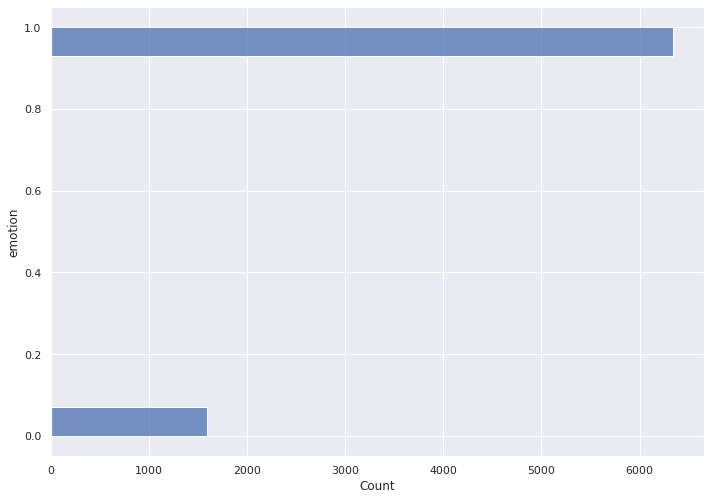

In [95]:
sns.histplot(emotion_data_w_neutral_bin, y="emotion")

In [97]:
emotion_data_w_neutral_bin["emotion"].value_counts(normalize=True)

1    0.799294
0    0.200706
Name: emotion, dtype: float64

In [98]:
emotion_data_w_neutral_bin.to_csv("emotion_data_bin_valid.csv", index=False)



---



### Emotion classification


In [100]:
emotion_data = empdialogues_train[(empdialogues_train["utterance_idx"] % 2) == 1]
emotion_data = emotion_data[["utterance", "context"]]
emotion_data.head()


,utterance,context
0,I remember going to see the fireworks with my ...,sentimental
2,This was a best friend. I miss her.,sentimental
4,We no longer talk.,sentimental
6,it feels like hitting to blank wall when i se...,afraid
8,dont you feel so.. its a wonder,afraid


In [101]:
emotion_data.to_csv("emotion_data_class.csv", index=False)

In [105]:
emotion_data.to_csv("emotion_data_class_valid.csv", index=False)



---



### Empathy assessment

In [106]:
empdialogues_train["tags"].value_counts()

<UNIGRAM>                   347
<HI>                        169
<POLITICAL>                 134
<UNIGRAM> <NUMERAL>          82
<IRREGULAR_COLON_FORMAT>     13
<HI> <UNIGRAM>               10
Name: tags, dtype: int64

In [ ]:
empdialogues_train["selfeval"][0] # Corresponds to empathy, relevance, and understandability by two different evaluators

'5|5|5_2|2|5'

In [138]:
df_to_clean = empdialogues_train[~empdialogues_train["selfeval"].map(valid_eval)]
df_clean = empdialogues_train[empdialogues_train["selfeval"].map(valid_eval)]

In [108]:
selfeval_sep = df_clean["selfeval"].str.split("_")
selfeval_grouped = selfeval_sep.apply(lambda x: list(zip(x[0].split("|"),x[1].split("|"))))

empathy_vals = selfeval_grouped.apply(lambda x: x[0])
relevance_vals = selfeval_grouped.apply(lambda x: x[1])
understandability_vals = selfeval_grouped.apply(lambda x: x[2])

In [109]:
empathy_vals = pd.concat([empathy_vals.apply(lambda x: int(x[0])),empathy_vals.apply(lambda x: int(x[1]))], axis=0)
relevance_vals = pd.concat([relevance_vals.apply(lambda x: int(x[0])),relevance_vals.apply(lambda x: int(x[1]))], axis=0)
understandability_vals = pd.concat([understandability_vals.apply(lambda x: int(x[0])),understandability_vals.apply(lambda x: int(x[1]))], axis=0)

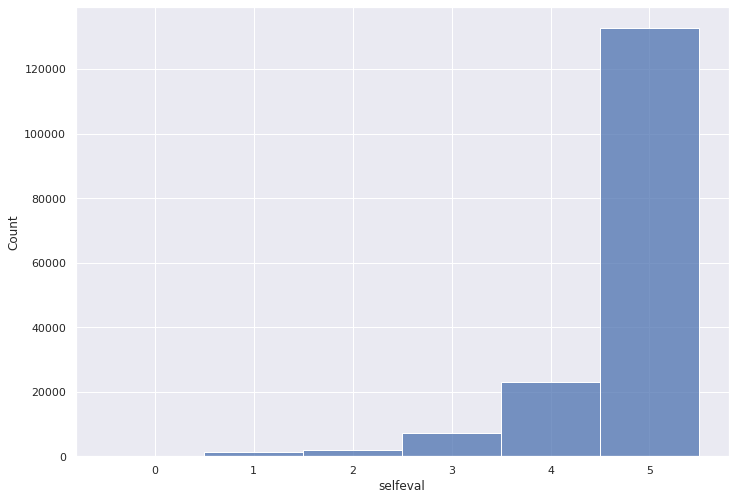

In [110]:
sns.histplot(empathy_vals, discrete=True)

In [111]:
empathy_vals.value_counts(normalize=True)

5    0.799755
4    0.138414
3    0.042623
2    0.011123
1    0.008036
0    0.000048
Name: selfeval, dtype: float64

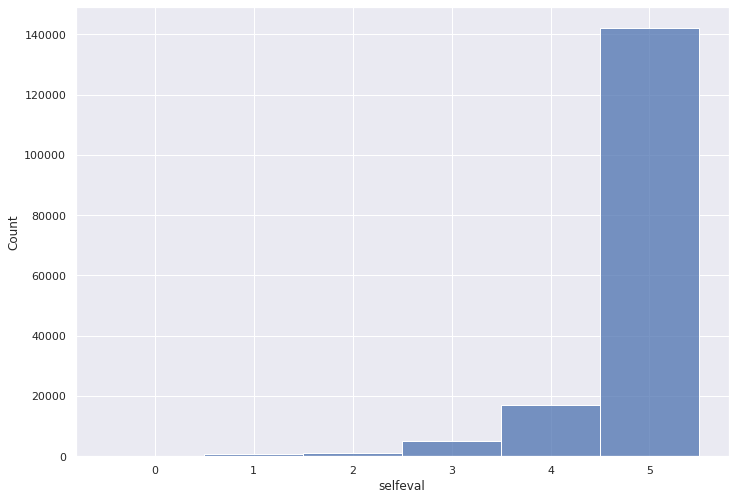

In [112]:
sns.histplot(relevance_vals, discrete=True)

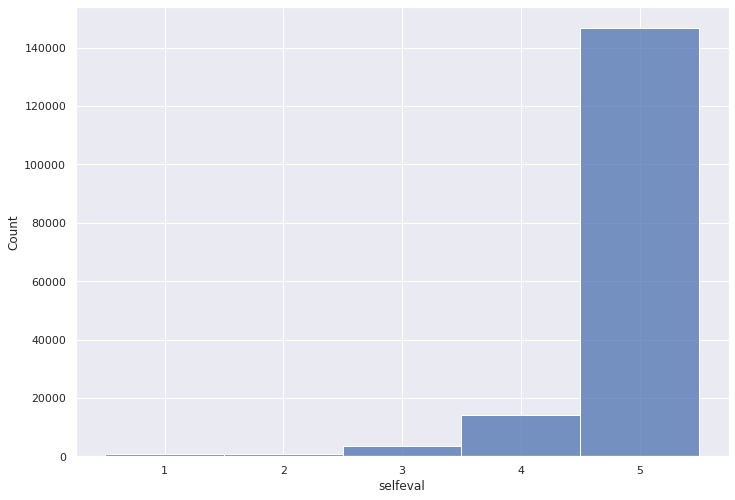

In [113]:
sns.histplot(understandability_vals, discrete=True)

In [139]:
df_clean.shape

(82936, 8)

In [116]:
df_clean.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,selfeval_grouped
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,2
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,2
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,2
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,2
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,2


In [140]:
selfeval_sep = df_clean["selfeval"].str.split("_")
min_empathy_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[0]))
min_relevance_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[1]))
min_understandability_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[2]))

df_clean["min_empathy_eval"] = min_empathy_eval
df_clean["min_relevance_eval"] = min_relevance_eval
df_clean["min_understandability_eval"] = min_understandability_eval

df_clean = df_clean[(df_clean["utterance_idx"] % 2) == 0]
df_clean["context_utterance"] = df_clean.apply(lambda x: f"{x.context} - {x.utterance}", axis=1)
df_clean = df_clean[["context_utterance", "min_empathy_eval", "min_relevance_eval", "min_understandability_eval"]]
df_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

(39675, 4)

In [119]:
df_clean.to_csv("empathy_data_assessment.csv", index=False)

In [133]:
empdialogues_valid = pd.read_csv("valid.csv", sep=",", encoding='utf-8', engine="python", escapechar="\\", error_bad_lines=False)

In [134]:
empdialogues_valid

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,4|5|5_5|5|5,NaN
1,hit:3_conv:6,2,terrified,Today_comma_as i was leaving for work in the m...,7,Are you fine now?,4|5|5_5|5|5,NaN
2,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,4|5|5_5|5|5,NaN
3,hit:3_conv:6,4,terrified,Today_comma_as i was leaving for work in the m...,7,Cool :) Is your car damaged a lot?,4|5|5_5|5|5,<IRREGULAR_COLON_FORMAT>
4,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,4|5|5_5|5|5,NaN
...,...,...,...,...,...,...,...,...
7289,hit:12361_conv:24722,4,prepared,One time I studied all night for my final exam!,46,tha is really cool what was your grade,4|4|5_4|4|3,NaN
7290,hit:12392_conv:24785,1,furious,One of my coworkers has been arguing with his ...,791,One of my coworkers has been arguing with his ...,4|5|5_5|5|5,NaN
7291,hit:12392_conv:24785,2,furious,One of my coworkers has been arguing with his ...,829,What are they arguing about?,4|5|5_5|5|5,NaN
7292,hit:12392_conv:24785,3,furious,One of my coworkers has been arguing with his ...,791,Everything and anything. It's annoying_comma_ ...,4|5|5_5|5|5,NaN


In [135]:
df_clean = empdialogues_valid[empdialogues_valid["selfeval"].map(valid_eval)]
selfeval_sep = df_clean["selfeval"].str.split("_")
min_empathy_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[0]))
min_relevance_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[1]))
min_understandability_eval = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[2]))

df_clean["min_empathy_eval"] = min_empathy_eval
df_clean["min_relevance_eval"] = min_relevance_eval
df_clean["min_understandability_eval"] = min_understandability_eval

df_clean = df_clean[(df_clean["utterance_idx"] % 2) == 0]
df_clean["context_utterance"] = df_clean.apply(lambda x: f"{x.context} - {x.utterance}", axis=1)
df_clean = df_clean[["context_utterance", "min_empathy_eval", "min_relevance_eval", "min_understandability_eval"]]
df_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,context_utterance,min_empathy_eval,min_relevance_eval,min_understandability_eval
1,terrified - Are you fine now?,4,5,5
3,terrified - Cool :) Is your car damaged a lot?,4,5,5
6,surprised - That's funny_comma_ hope he didn't...,3,5,5
8,surprised - I would probably scream also.,3,5,5
14,disgusted - Thats horrible_comma_ hope he is ok.,3,4,5


In [137]:
df_clean.to_csv("empathy_data_assessment_valid.csv", index=False)



---



In [ ]:
selfeval_grouped_diff = selfeval_sep.apply(lambda x: list(zip(x[0].split("|"),x[1].split("|")))[0])
diff_eval = selfeval_grouped_diff.apply(lambda x: abs(int(x[0]) - int(x[1])))
sum(diff_eval > 0)

27176

In [ ]:
root_speaker = {}
for ix, row in df_clean[df_clean["utterance_idx"] == 2][["conv_id", "speaker_idx"]].iterrows():
    root_speaker[row.conv_id] = row.speaker_idx

In [ ]:
df_empathetic = pd.DataFrame({"utterance": [], "context": []})
for conv_id, speaker_idx in root_speaker.items():
    sample = df_clean[(df_clean["conv_id"] == conv_id) & (df_clean["speaker_idx"] == speaker_idx)][["utterance","context", "selfeval_grouped"]]
    df_empathetic = pd.concat([df_empathetic, sample], axis=0)

In [ ]:
df_empathetic.shape

(39674, 3)

In [ ]:
df_empathetic.head()

,utterance,context,selfeval_grouped
1,Was this a friend you were in love with_comma_...,sentimental,2
3,Where has she gone?,sentimental,2
5,Oh was this something that happened because of...,sentimental,2
7,Oh ya? I don't really see how,afraid,3
9,I do actually hit blank walls a lot of times b...,afraid,3


<AxesSubplot:xlabel='selfeval_grouped', ylabel='Count'>

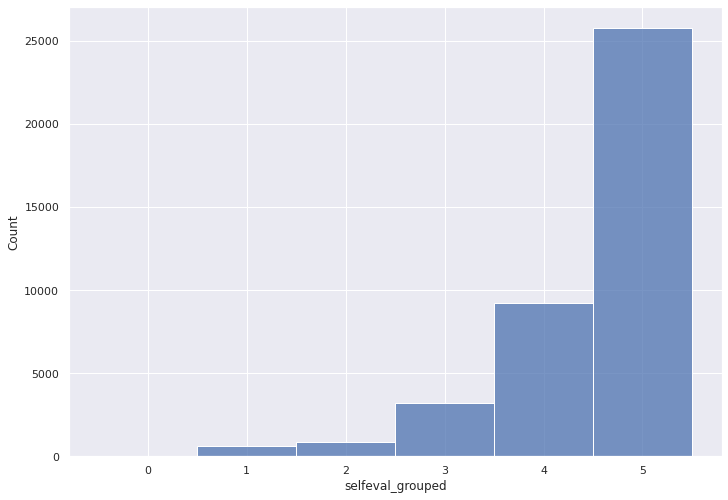

In [ ]:
sns.histplot(df_empathetic["selfeval_grouped"], discrete=True)

df_empathetic.to_csv("data/preprocessed/empathy_assessment.csv", index=False)